In [1]:
import torch
import numpy as np
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torchvision import transforms, models

import pickle
import tensorflow as tf
import time

import matplotlib.pyplot as plt
%matplotlib inline

if torch.cuda.is_available():  
    DEVICE = "cuda:0" 
else:  
    DEVICE = "cpu"
print(DEVICE)

cuda:0


In [2]:
writer = SummaryWriter(comment = '_mobileNet-v2')

### Load & Preprocessing  Data

In [3]:
# Comes in:
# x: N x 32 x 32 x 3
# y: N x 1
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

x_train = np.transpose(x_train, [0, 3, 1, 2]) # x: N x 3 x 32 x 32 
x_test = np.transpose(x_test, [0, 3, 1, 2]) # x: N x 3 x 32 x 32 
x_train, x_test = x_train / 256, x_test / 256 # Normalize to [0, 1]

In [4]:
train_preprocess = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    #transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    #transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
X_train = torch.tensor(x_train).float()
X_test = torch.tensor(x_test).float()
y_train = torch.tensor(y_train).squeeze().long()
y_test = torch.tensor(y_test).squeeze().long()

In [6]:
class Dataset(data.Dataset):
    def __init__(self, data, labels, flag = 'eval'):
        self.data = data
        self.labels = labels
        self.flag = flag 
        
    def __len__(self):
        return len(self.labels)
    
    # Get one sample
    def __getitem__(self, index):
        if self.flag == 'eval':
            return preprocess(self.data[index]), self.labels[index]
        elif self.flag == 'train':
            return train_preprocess(self.data[index]), self.labels[index]

In [7]:
# Put into dataloader
trainset = Dataset(X_train, y_train, flag = 'train')
trainloader = data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

train4eval = Dataset(X_train, y_train)
evalloader = data.DataLoader(train4eval, batch_size=100, shuffle=False, num_workers=2)

testset = Dataset(X_test, y_test)
testloader = data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

### Model

In [8]:
model = models.mobilenet_v2(pretrained=True)
num_classes = 100
model.fc = nn.Linear(512, num_classes)

In [9]:
## Training Routine
def training_routine(model, train_generator, test_generator, n_epochs, writer = writer,  
                     eval_every=5):
    train_generator, eval_generator = train_generator
    
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr =0.01, 
                                momentum = 0.9, weight_decay = 0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.8)
    #optimizer = torch.optim.RMSprop(model.parameters(), lr =0.045, 
    #                            momentum = 0.9, weight_decay = 0.00004)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma = 0.98)
    accuracies = []
    
    for i in range(n_epochs):
        # Iterate over batches
        batch_losses = []
        
        for X_batch, y_batch in train_generator:
            optimizer.zero_grad()
            # forward pass
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            batch_output = model(X_batch)
            batch_loss = criterion(batch_output, y_batch)
            # backward pass and optimization
            batch_loss.backward()
            optimizer.step()
            batch_losses.append(batch_loss.cpu().detach())
        print("Epoch {} | training loss: {}".format(i, np.mean(batch_losses)))
        writer.add_scalar('Loss/train', np.mean(batch_losses), i)
        scheduler.step()
        
        # Once every 100 iterations, print statistics
        if i%eval_every==0:
            train_accuracy = []
            test_accuracy = []
            for X_batch, y_batch in eval_generator:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                batch_output = model(X_batch)
                batch_prediction = batch_output.cpu().detach().argmax(dim=1)
                train_accuracy.append((batch_prediction.numpy()==y_batch.cpu().numpy()).mean())
                
            for X_batch, y_batch in test_generator:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                batch_output = model(X_batch)
                batch_prediction = batch_output.cpu().detach().argmax(dim=1)
                test_accuracy.append((batch_prediction.numpy()==y_batch.cpu().numpy()).mean())
            print("Epoch {} | train acc: {}, test acc: {}".format(i, np.mean(train_accuracy), np.mean(test_accuracy)))
            writer.add_scalar('Accuracy/train', np.mean(train_accuracy), i)
            writer.add_scalar('Accuracy/test', np.mean(test_accuracy), i)
            
            accuracies.append((i, np.mean(train_accuracy), np.mean(test_accuracy)))
            
    return model.cpu(), accuracies

In [10]:
start = time.time()
trained_net, accuracies = training_routine(model, (trainloader, evalloader), testloader, 51)
end = time.time()
print((end - start)/60) 

Epoch 0 | training loss: 3.6391971111297607
Epoch 0 | train acc: 0.38718, test acc: 0.37709999999999994
Epoch 1 | training loss: 2.448592185974121
Epoch 2 | training loss: 2.0879106521606445
Epoch 3 | training loss: 1.916553020477295
Epoch 4 | training loss: 1.8218846321105957
Epoch 5 | training loss: 1.6556181907653809
Epoch 5 | train acc: 0.6844, test acc: 0.6317
Epoch 6 | training loss: 1.608718752861023
Epoch 7 | training loss: 1.5602279901504517
Epoch 8 | training loss: 1.5233337879180908
Epoch 9 | training loss: 1.4860268831253052
Epoch 10 | training loss: 1.3868447542190552
Epoch 10 | train acc: 0.7512000000000001, test acc: 0.6817
Epoch 11 | training loss: 1.362863302230835
Epoch 12 | training loss: 1.347928762435913
Epoch 13 | training loss: 1.3351447582244873
Epoch 14 | training loss: 1.3268625736236572
Epoch 15 | training loss: 1.2363476753234863
Epoch 15 | train acc: 0.7854800000000001, test acc: 0.6966000000000001
Epoch 16 | training loss: 1.2234251499176025
Epoch 17 | tra

In [11]:
model_dict = trained_net.state_dict()
torch.save(model_dict, "mobileNet")

In [12]:
# Load some version of saved model
model = models.mobilenet_v2(pretrained=True)
model.fc = nn.Linear(512, num_classes)
state_dict = torch.load("mobileNet")
model.load_state_dict(state_dict)

<All keys matched successfully>

### Evaluation

In [13]:
y_pred = []
model = model.cuda()
for local_batch, local_labels in testloader:
    local_batch, local_labels = local_batch.cuda(), local_labels.cuda()
    batch_output = model(local_batch)
    batch_prediction = batch_output.cpu().detach().argmax(dim=1)
    y_pred.append(batch_prediction)
y_pred = torch.cat(y_pred).numpy()

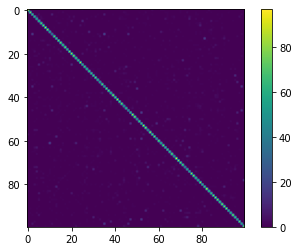

In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
n_classes = 100

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
plt.colorbar()

Text(0.5, 0, '# of Epochs')

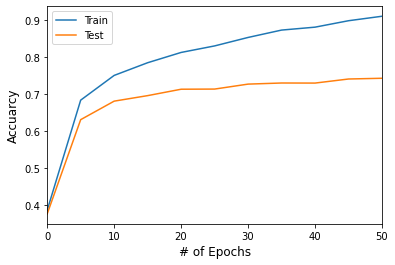

In [15]:
accuracies = np.array(accuracies)
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.plot(accuracies[:, 0], accuracies[:, 1], label = "Train")
ax.plot(accuracies[:, 0], accuracies[:, 2], label = 'Test')
ax.legend(fontsize = 10)
ax.set_xlim((0,50))
ax.set_ylabel('Accuarcy', fontsize = 12)
ax.set_xlabel("# of Epochs", fontsize = 12)